# Plot properties on lineage tree

In this notebook we provide code to show the  distribution of extracted properties of cells plotted on a lineage tree

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

## Set paths

Set the paths to the dataframe generated in notebooks 2

In [4]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'I2ICourse', 'Project2B')
df_file = proj_dir / 'ProcessedData' / 'Position000000_dataframe.csv'

## Define lineage class

Below we define the class to create a lineage tree

In [9]:
class lineage_tree_2d():
    """This class creates a 2D lineage tree and plots this
    """
    
    def __init__(self, df, cell_prop, frame_int=1):
        """ 2D lineage tree for plotting.
        
        Usage: 
        
        lt = lineage_tree_2d(data_frame, cell_prop_to_show, [frame_int=frame_interval])
        
        lt.plot_lin_tree()
        

        Parameters
        ----------
        df : pandas dataframe
            lineage data frame of colony to plot. colony should start with 1 or 2 cells
        cell_prop : string
            column name of dataframe which is added as colormap to lineage tree
        frame_int : int, optional
            frame interval in minutes, by default 1
        """
        self.df = df
        self.cell_prop = cell_prop
        
        self.dt = frame_int
        
        self.x = []
        self.y = []
        self.c = []
        
        self.xl1 = []
        self.xl2 = []
 
        self.yl1 = []
        self.yl2 = []               
        
        first_cells = self.df.loc[self.df['frames']==0,'id_cell'].to_list()
        
        for i, cellid in enumerate(first_cells):
            if len(first_cells)==1:
                xc = 0
                dx = 2
            elif len(first_cells)==2:
                xc = -1 if i==0 else 1
                dx = 1
            else:
                Exception('Can only handle up to 2 starting cells!')
            
            self._add_cell_to_lin(cellid, xc, dx)
                

    def _add_cell_to_lin(self, cellid, xc, dx):
        """_summary_

        Parameters
        ----------
        cellid : int
            cell_id to plot
        xc : float
            x-position to plot cell at
        dx : float
            step in x-position between sister cells
        """
        #get frames cell
        frames = self.df.loc[self.df['id_cell']==cellid, 'frames'].to_list()
        #get property cell
        props = self.df.loc[self.df['id_cell']==cellid, self.cell_prop].to_list()
        
        for fr, prop in zip(frames, props):
            #add current node
            self.x.append(xc)
            self.y.append(fr * self.dt)
            self.c.append(prop)
            
            #add edge to next frame
            if fr < frames[-1]:
                self.xl1.append(xc)
                self.xl2.append(xc)
                self.yl1.append(fr * self.dt)
                self.yl2.append((fr+1) * self.dt)  
         
           
        #reduce spacing for next generation              
        dx = dx/2
            
        #recursively call on next generation, d1        
        d1 = self.df.loc[self.df['id_cell']==cellid, 'id_d1'].unique().item() 
        if d1 > -1:
            xc_d1 = xc - dx
            self._add_cell_to_lin(d1, xc_d1, dx)
            
            #add connecting edge
            self.xl1.append(xc)
            self.xl2.append(xc_d1)
            self.yl1.append(frames[-1] * self.dt)
            self.yl2.append((frames[-1]+1) * self.dt)

         #recursively call on next generation, d2 
        d2 = self.df.loc[self.df['id_cell']==cellid, 'id_d2'].unique().item()  
        if d2 > -1:
            xc_d2 = xc + dx
            self._add_cell_to_lin(d2, xc_d2, dx)
            
            #add connecting edge
            self.xl1.append(xc)
            self.xl2.append(xc_d2)
            self.yl1.append(frames[-1] * self.dt)
            self.yl2.append((frames[-1]+1) * self.dt)
    
    
    def plot_lin_tree(self, cb_int=1, cb_label=None, marker_size=4):
        """Plots 2D lineage tree

        Parameters
        ----------
        cb_int : int, optional
            min and max colorbar values should be multiple of this, by default 1
        cb_label : string, optional
            color bar label, by default None
        marker_size: float, optional
            size of markers    

        Returns
        -------
        fig, axs
            pyplot figure and axis handles
        """
        
        sns.set_style("ticks")

        fig, axs = plt.subplots(1, figsize=(8,5))
        l = axs.plot(np.array([self.xl1, self.xl2]), 
                np.array([self.yl1, self.yl2]),
                linewidth=1, color=[0.85,0.85,0.85], zorder=0); 

        cnorm = (np.floor(min(self.c)/cb_int) * cb_int, np.ceil(max(self.c)/cb_int) * cb_int) 

        s = axs.scatter(self.x, self.y, c=self.c, marker='s', s=marker_size, 
                        cmap='plasma', vmin=cnorm[0], vmax=cnorm[1], zorder=1)
        cb = fig.colorbar(s, ax=axs)
        
        #set cb-label
        cb_label is self.cell_prop if cb_label is None else cb_label
        cb.set_label(cb_label)
        
        axs.set_xticks([])
        axs.set_ylabel('time [min.]')    
        
        return fig, axs

## Load Data
We load the data from the last notebook;

In [6]:
#get data frame
df = pd.read_csv(df_file)

## Plot data

you can set `property_to_show` to any column name in the dataframe

In [7]:
df.columns

Index(['Unnamed: 0', 'id_seg', 'id_cell', 'id_par', 'id_colony', 'id_d1',
       'id_d2', 'id_sib', 'frames', 'new_pole', 'old_pole', 'edges', 'length',
       'width', 'area', 'perimeter', 'fluo1', 'x_pos', 'y_pos', 'generation',
       'age'],
      dtype='object')

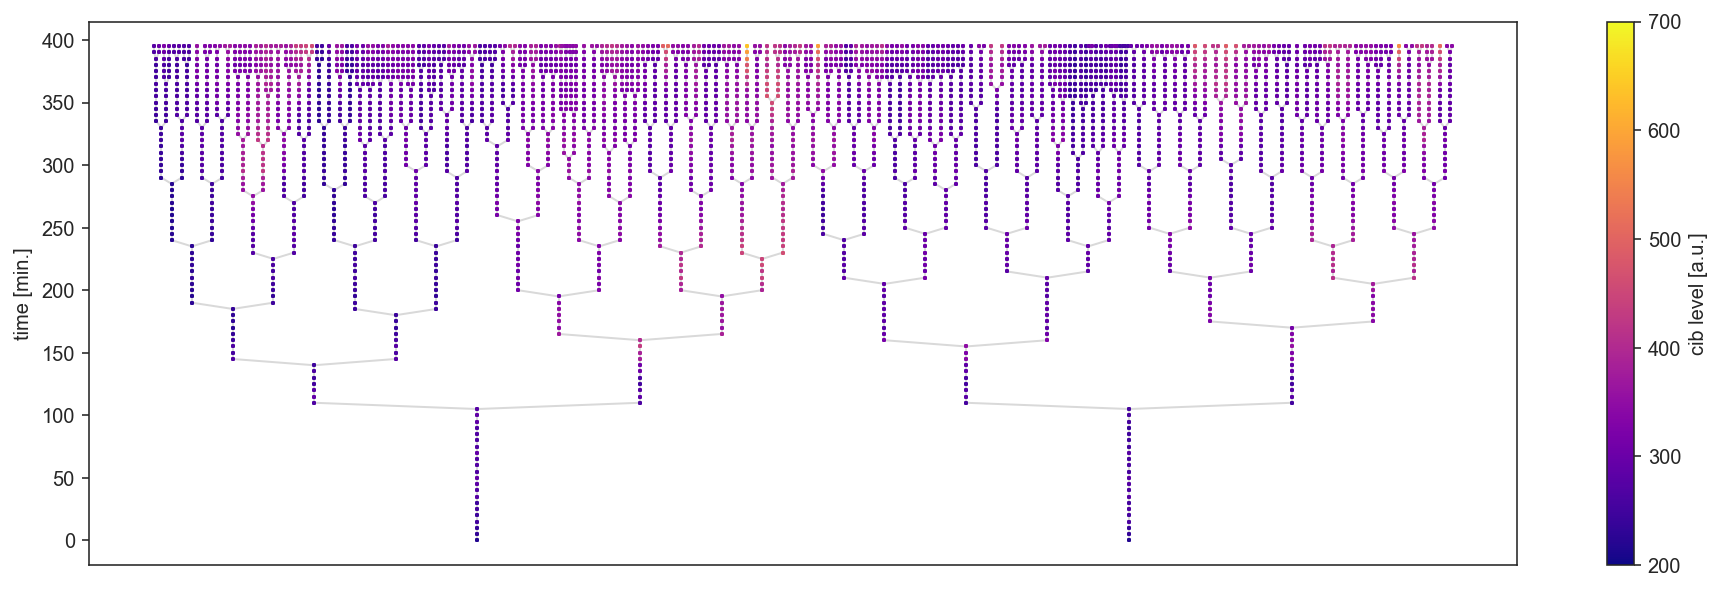

In [14]:
property_to_show = 'fluo1'
#loop over all frames
lt1 = lineage_tree_2d(df, property_to_show, frame_int=5)  
fig, axs = lt1.plot_lin_tree(cb_int=100, cb_label='cib level [a.u.]',marker_size=1)
fig.set_size_inches((16,5))